# INFO2950 PROJECT PHASE 2
**Project Members:**
Brittany Sun, Hilary Cabrera Orozco, Jessie Lee, Wen Chen

**Resources Used For Debugging/Guidance:**

[Stack Overflow | BeautifulSoup - Scrape Table Without A Class](https://stackoverflow.com/questions/61190748/beautifulsoup-scrape-table-without-a-class)
- INFO2950 only taught web scraping through using element classes/tags/attributes; Stack Overflow was used to learn how to scrape HTML elements without classes/tags/attributes

[SaturnCloud | How to Extract First and Last Words from Strings as a New Column in Pandas](https://saturncloud.io/blog/how-to-extract-first-and-last-words-from-strings-as-a-new-column-in-pandas/#:~:text=We%20can%20do%20this%20using%20the%20str%20accessor%2C%20which%20allows,indexing%20(%20%5B0%5D%20).)
- referred str.split documentation and examples

[Stack Overflow | How to extract data from a filename in python?](https://stackoverflow.com/questions/71214436/how-to-extract-data-from-a-filename-in-python-convert-file-name-to-string)
- iterating over files in a folder/directory; use os module built in python


***

### **Research Question:**

Our main research question is: **Does your socioeconomic status impact your flight?**

Originally, we wanted to look into the prices of flights in upstate New York in congruency with Cornell University's scheduled breaks. However, we quickly realized this prediction is not only limited, leaving less room for broader implications, the results were rather intuitively correlated. Therefore, we decided to broaden our approach, and look into the cost of flights in relation to passenger demographics. 

We are interested in more specific research questions listed below:
- Which airports are the most cost-effective to fly out of? Which airports have the most routes?
    - Are there more routes in more affluent areas compared to other areas?
- Do areas of different socioeconomic statuses affect flight prices for different airports?
- Are flights departing on time more depending on the airport? Does the departure time depend on the socioeconomic status of the area?
- Where are flights more expensive in relation to the income of a county?
- Have the prices of flights from airports changed over time? Did an airport get more expensive compared to another?

We will sift through data to analyze how  departure, route availability, flight pricing, and pricing trends are impacted by socioeconomic status of individuals and the region. In summary, we want to know if time and accessibility  exploits are causes of lower socioeconomic status. 


***

### Importing Packages

In [4]:
# importing packages for data cleaning and analysis from info2950 kernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb
import requests
from bs4 import BeautifulSoup
import time

import os

***

### **DATA COLLECTION AND CLEANING**

**Dataset:** Airline Routes

**Author/Source:** OpenFlights

**Link:** https://openflights.org/data.php#airport

Below we provide several datasets to conduct our analysis on whether socioeconomic status impacts one's flight.

First, we access a global database of airports by webscraping https://openflights.org/data.php#airport. With this source, we are able to collect data on Airline, Airline ID, Source airport, Source airport ID, Destination airport, Destination airport ID, Codeshare, Stops, and Equipment.


In [5]:
# webscraping for dataset column names
routes_url = "https://openflights.org/data.php#airport"

routes_result = requests.get(routes_url)
routes_text = routes_result.text
page = BeautifulSoup(routes_text, "html.parser")

tables = page.find_all('table')

# tables have no attributes/tags/classes to specifically look for
# the table needs to be indexed instead
table = tables[6]
table_rows = table.find_all("tr")

column_names = []

for row in table_rows:
    name = row.find('td', {'class': 'head'})
    
    if name != None:
        name = name.text

    column_names.append(name)

print(column_names)

['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment']


Once we narrowed the columns of information needed, we import our data from routes.csv to the respective columns. 

In [6]:
# importing data from csv file into dataframe
routes = pd.read_csv('data/routes.csv', header = None)

# adding webscraped column names to dataframe
routes.columns = column_names
print(routes.head(5))

  Airline Airline ID Source airport Source airport ID Destination airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   
2      2B        410            ASF              2966                 MRV   
3      2B        410            CEK              2968                 KZN   
4      2B        410            CEK              2968                 OVB   

  Destination airport ID Codeshare  Stops Equipment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2  
2                   2962       NaN      0       CR2  
3                   2990       NaN      0       CR2  
4                   4078       NaN      0       CR2  


Below, as part of data cleaning to our needed information, we count the total number of outbound routes at a given airport.

In [7]:
# counting total number of routes for each airport
airport_route_count = routes.value_counts("Source airport")
airport_route_count = pd.DataFrame(airport_route_count)
airport_route_count = airport_route_count.reset_index(). \
    rename(columns = {'Source airport': 'source_airport'})
airport_route_count.head()

,source_airport,count
0,ATL,915
1,ORD,558
2,PEK,535
3,LHR,527
4,CDG,524


**Dataset:** US Airport Codes

**Author/Source:** Leonard's Guide

**Link:** https://www.leonardsguide.com/us-airport-codes.shtml

We want to analyze trends of United States domestic routes. With this dataset, we are cross-referencing its list of US Airport Codes with all airport codes from the previous dataset to only keep domestic airports.

In [8]:
# removing non-US airports from routes
us_airports  = "https://www.leonardsguide.com/us-airport-codes.shtml"
airports_result = requests.get(us_airports)
airports_text = airports_result.text
page = BeautifulSoup(airports_text, "html.parser")

table = page.find('table')
table_rows = table.find_all('td')

airport_list = []

for row in table_rows:
    row = row.text
    if len(row) == 3:
        airport_list.append(row)

us_airport_df = pd.DataFrame(airport_list, columns=['Airport'])
print(us_airport_df)

    Airport
0       BHM
1       DHN
2       HSV
3       MOB
4       MGM
..      ...
182     MSN
183     CPR
184     CYS
185     JAC
186     RKS

[187 rows x 1 columns]


**Dataset:** Average Domestic Airline Itinerary Fares

**Author/Source:** Bureau of Transportation Statistics

**Link:** https://www.transtats.bts.gov/AverageFare/

Now that we have cleaned our database to only U.S. airports, we now want to figure out the average fare at each respective airport. We complete this by iterating through AverageFare files, removing NaN and organizing into columns by quarter and year. 

In [9]:
# importing excel files into dataframe(s)
# for loop to iterate over Average Fare data files

avg_fare_df = pd.DataFrame()

for file in os.listdir('data'):
    if 'AverageFare' in file:
        # removing table name from column names and moving column names to header
        yearly_data = pd.read_csv('data/' + file)
        yearly_data.columns = yearly_data.iloc[0]
        yearly_data = yearly_data[1:]

        # removing nan columns
        yearly_data = yearly_data.dropna(axis=1, how='all')

        # finding year for new columns
        year_index = file.find('.csv')
        year = file[year_index - 4:year_index]

        # creating new columns for quarter and year
        yearly_data['Year'] = year

        # adding smaller quarterly dataframes to the larger dataframe
        avg_fare_df = pd.concat([avg_fare_df, yearly_data])

avg_fare_df.columns.values[6] = 'inflation_adjusted_avg_fare'


We will take our cleaned and processed data and combine AverageFare with the rest of the columns in our larger dataframe.

In [10]:
# renaming avg_fare_df columns without spaces + selecting columns
avg_fare_df = duckdb.sql('SELECT "Airport Code" AS airport_code, \
                         "Airport Name" AS airport_name, \
                         "City Name" as city_name, \
                         "State Name" AS state_name, \
                         "Average Fare ($)" AS avg_fare, \
                         inflation_adjusted_avg_fare, \
                         "Year" AS year \
                         FROM avg_fare_df').df()

print(avg_fare_df.head(5))

# joining dataframes together
combined_df = duckdb.sql('SELECT avg_fare_df.*, \
                         us_airport_df.Airport AS airport, \
                         airport_route_count.source_airport, \
                         airport_route_count.count AS routes \
                         FROM avg_fare_df \
                         INNER JOIN us_airport_df \
                         ON avg_fare_df.airport_code = us_airport_df.Airport \
                         INNER JOIN airport_route_count \
                         ON us_airport_df.Airport = \
                         airport_route_count.source_airport').df()

#checking if airport and source_airport columns have the same data
if (combined_df['airport'].all() == combined_df['source_airport'].all()):
    print('airport and source_airport are identical.')

    # dropping airport column if it has the same data
    combined_df = combined_df.drop(columns=['airport'])
    print('dropped airport column.')

# custom function to slice city names, getting the first important city name
def slice_city_name_combined(city):
    if '-' in city:
        return city.split('-')[0]
    elif '/' in city:
        return city.split('/')[0]
    return city

combined_df['city_name'] = \
    combined_df['city_name'].apply(slice_city_name_combined)

combined_df.head()

  airport_code                              airport_name       city_name  \
0          LAX                 Los Angeles International     Los Angeles   
1          ORD              Chicago O'Hare International  Chicago-O'Hare   
2          DEN                      Denver International          Denver   
3          ATL  Hartsfield-Jackson Atlanta International         Atlanta   
4          EWR              Newark Liberty International          Newark   

  state_name          avg_fare inflation_adjusted_avg_fare  year  
0         CA  401.842173324443            547.920020001648  2012  
1         IL  385.047290417769            525.019853744782  2012  
2         CO  320.908580358108            437.565411101214  2012  
3         GA  365.824746315277            498.809521807781  2012  
4         NJ   477.06114941498            650.482631942219  2012  
airport and source_airport are identical.
dropped airport column.


,airport_code,airport_name,city_name,state_name,avg_fare,inflation_adjusted_avg_fare,year,source_airport,routes
0,LAX,Los Angeles International,Los Angeles,CA,401.842173324443,547.920020001648,2012,LAX,492
1,ORD,Chicago O'Hare International,Chicago,IL,385.047290417769,525.019853744782,2012,ORD,558
2,DEN,Denver International,Denver,CO,320.908580358108,437.565411101214,2012,DEN,361
3,ATL,Hartsfield-Jackson Atlanta International,Atlanta,GA,365.824746315277,498.809521807781,2012,ATL,915
4,EWR,Newark Liberty International,Newark,NJ,477.06114941498,650.482631942219,2012,EWR,253


**Dataset:** Real personal income and real personal consumption expenditures by state, MSA, and metro/nonmetro portion

**Author/Source:** Bureau of Economic Analysis (BEA)

**Link:** https://apps.bea.gov/regional/downloadzip.htm?_gl=1

The BEA data includes personal income and consumption expenditure statistics at the state and metropolitan levels. This information allows us to categorize airports based on the income levels of their surrounding areas, helping us analyze how wealth correlates with air travel costs, route availability, and delays.

In [11]:
# importing data from csv files

# metropolitan areas/cities (real personal income)
income_df = pd.read_csv('data/MARPI_MSA_2008_2022.csv')

# removing rows that are country-wide (united states) and not county-level
income_df = income_df.drop([0, 1]).reset_index(drop=True)
income_df.rename(columns={"GeoName": "city_name"}, inplace=True)
income_df['city_name'] = income_df['city_name'].astype(str)

income_df['state_name'] = income_df['city_name'].str.split(', ').str[1].str[:2]
income_df = income_df.drop(columns=['GeoFIPS', 'Region', 'TableName', \
                                    'LineCode', 'IndustryClassification'])

# split income_df city_name into the city/county name and state code
# check if income_df's city name is in combined_df's city_name
# check if income_df's state code is the combined_df's state_name

# if both are true, 
# then add the real personal income to merged_df (years: 2008-2022)

merged_df = duckdb.sql("SELECT * \
                       FROM combined_df \
                       JOIN income_df \
                       ON income_df.city_name \
                       LIKE '%' || combined_df.city_name || '%' \
                       AND income_df.state_name = combined_df.state_name \
                       WHERE income_df.Description = \
                       'Real per capita personal income (constant (2017) dollars) 2/' \
                       ORDER BY combined_df.city_name ASC").df()

merged_df = merged_df.drop(columns = ['city_name', 'state_name_1', \
                                      'Description', 'Unit'])

yearly_real_income_df = merged_df.loc[:, \
                                      ['airport_code', \
                                       '2008', '2009', '2010', '2011', \
                                        '2012', '2013', '2014', '2015', \
                                        '2016', '2017', '2018', '2019', \
                                        '2020', '2021', '2022']]

yearly_real_income_df = pd.melt(yearly_real_income_df, \
                                id_vars=['airport_code'], \
                                value_vars=['2008', '2009', '2010', \
                                            '2011', '2012', '2013', '2014', \
                                            '2015', '2016', '2017', '2018', \
                                            '2019', '2020', '2021', '2022'],
                                var_name='year', \
                                value_name='per_capita_personal_income')

yearly_real_income_df = yearly_real_income_df.drop_duplicates().\
    reset_index(drop=True)

yearly_real_income_df.sample(5).head()

,airport_code,year,per_capita_personal_income
2110,SHV,2021,56317.0
1924,SWF,2020,51550.0
1137,OGG,2015,40155
346,DSM,2010,49004
2005,MDW,2021,62810.0


The merged_df is very wide and difficult to use for analysis. The left side of the dataframe that consists of the years (2008-2022) as columns as particularly wide so it was indexed from the main dataframe, manipulated to be tidy/long rather than wide, and re-merged into the main dataframe.

In [12]:
# only selecting columns that are not the years 2008-2022
merged_df = merged_df.iloc[:, :9]

# merging long/tidy yearly_real_income_df 
# with selected columns from merged_df to get final dataframe
tidied_df = merged_df.merge(yearly_real_income_df, \
    on=['year', 'airport_code'], how='inner')

# renaming city_name_1 to msa to represent data more accurately
tidied_df = tidied_df.rename(columns={'city_name_1': 'msa'})

# type of inflation_adjusted_avg_fare changed to float
tidied_df['inflation_adjusted_avg_fare'] = \
    pd.to_numeric(tidied_df['inflation_adjusted_avg_fare'], errors='coerce')
print(tidied_df['inflation_adjusted_avg_fare'].dtype)

# type of year changed to int
tidied_df['year'] = pd.to_numeric(tidied_df['year'], errors='coerce')
print(tidied_df['year'].dtype)
nan_count = tidied_df['year'].isna().sum()
print(nan_count)

# type of routes changed to int
tidied_df['routes'] = pd.to_numeric(tidied_df['routes'], errors='coerce')
print(tidied_df['routes'].dtype)
nan_count = tidied_df['routes'].isna().sum()
print(nan_count)

# type of personal_income_per_capita changed to float
tidied_df['per_capita_personal_income'] = \
    pd.to_numeric(tidied_df['per_capita_personal_income'], errors='coerce')

# checking/showing data for different airports for different years
tidied_df.head()

float64
int64
0
int64
0


,airport_code,airport_name,state_name,avg_fare,inflation_adjusted_avg_fare,year,source_airport,routes,msa,per_capita_personal_income
0,CAK,Akron-Canton Regional,OH,347.682886201964,459.770111,2014,CAK,22,"Akron, OH (Metropolitan Statistical Area)",47076.0
1,CAK,Akron-Canton Regional,OH,338.901191631125,455.427454,2013,CAK,22,"Akron, OH (Metropolitan Statistical Area)",45737.0
2,CAK,Akron-Canton Regional,OH,319.880565775489,436.163692,2012,CAK,22,"Akron, OH (Metropolitan Statistical Area)",45638.0
3,CAK,Akron-Canton Regional,OH,319.496725890112,416.739085,2016,CAK,22,"Akron, OH (Metropolitan Statistical Area)",48667.0
4,CAK,Akron-Canton Regional,OH,310.663034490362,432.361017,2011,CAK,22,"Akron, OH (Metropolitan Statistical Area)",45696.0


**Dataset:** U.S. Airports Ranked By Flight Cancellation Rates - 2022

**Author/Source:** insuremytrip

**Link:** https://www.insuremytrip.com/travel-advice/travel-planning/us-airport-statistics-flight-cancellation-data/#2023

The data collected and webscraped from insuremytrip are the flight cancellation rates of 75 US airports in 2022.

This dataframe is separate from the 'main' dataframe and will be used as a year-specific (2022) analysis of the flight cancellation rates and other variables like personal income per capita (from the 'main' dataframe)

In [13]:
performance_url = \
    "https://www.insuremytrip.com/travel-advice/travel-planning/us-airport-statistics-flight-cancellation-data/#2023"

performance_result = requests.get(performance_url)
performance_text = performance_result.text
page = BeautifulSoup(performance_text, "html.parser")

# finding the 2022 table of flight cancellations
tables = page.find_all('table', {'class': 'c25'})
table_2022 = tables[1]
table_rows = table_2022.find_all('tr', {'class': 'c11'})

airport_list = []
canceled_list = []

# for every row, find the airport code and percent of canceled flights
# append the data to the lists
for row in table_rows[1:]:
    airport = row.find('td', {'class': 'c12'})
    airport = airport.find('span')
    airport = airport.text
    airport_list.append(airport)

    canceled = row.find('td', {'class': 'c5'})
    canceled = canceled.find('span')
    canceled = canceled.text
    canceled_list.append(canceled)

print(airport_list)

print(canceled_list)

canceled_2022_df = pd.DataFrame({'airport_code': airport_list, \
    'percent_canceled_flights': canceled_list})
canceled_2022_df.head()

['BUF', 'RSW', 'LGA', 'EWR', 'DCA', 'DAL', 'PBI', 'BWI', 'MDW', 'MCO', 'JFK', 'CHS', 'ORF', 'CLE', 'CMH', 'TPA', 'PIT', 'IND', 'BDL', 'BOS', 'STL', 'SAV', 'SDF', 'RIC', 'JAX', 'RDU', 'BUR', 'BNA', 'DFW', 'CVG', 'FLL', 'ORD', 'MCI', 'MIA', 'HOU', 'ANC', 'PHL', 'MEM', 'MKE', 'CLT', 'AUS', 'DEN', 'MYR', 'IAD', 'OKC', 'MSY', 'SNA', 'SJU', 'ELP', 'OMA', 'LAS', 'SAT', 'OAK', 'SEA', 'SJC', 'DTW', 'SMF', 'PDX', 'IAH', 'SAN', 'ONT', 'PHX', 'ABQ', 'MSP', 'TUS', 'RNO', 'ATL', 'SFO', 'LAX', 'GEG', 'BOI', 'SLC', 'HNL', 'OGG', 'KOA']
['5.55%', '5.47%', '5.19%', '4.82%', '3.93%', '3.82%', '3.79%', '3.74%', '3.73%', '3.70%', '3.69%', '3.61%', '3.55%', '3.53%', '3.51%', '3.45%', '3.38%', '3.36%', '3.35%', '3.34%', '3.29%', '3.28%', '3.18%', '3.15%', '3.12%', '3.08%', '3.08%', '2.99%', '2.96%', '2.92%', '2.89%', '2.86%', '2.82%', '2.82%', '2.81%', '2.74%', '2.74%', '2.74%', '2.74%', '2.73%', '2.72%', '2.71%', '2.59%', '2.49%', '2.40%', '2.37%', '2.34%', '2.32%', '2.28%', '2.22%', '2.20%', '2.19%', '2.15

,airport_code,percent_canceled_flights
0,BUF,5.55%
1,RSW,5.47%
2,LGA,5.19%
3,EWR,4.82%
4,DCA,3.93%


## Export Cleaned Dataframes ##

In [14]:
tidied_df.to_csv('cleaned_data/tidied_df.csv', index=False)
canceled_2022_df.to_csv('cleaned_data/canceled_2022.csv', index=False)

***
### **DATA DESCRIPTION**

#### Raw Data Source Link:

[info2950_project Github repository](https://github.com/chen-wen-yu/info2950_project/tree/main/data)

Our project consists of datasets from several sources, each playing a critical role in exploring the connection between air travel and socioeconomic factors:

**Flight Route Data**

* Description: Sourced from OpenFlights, includes details on airline routes globally. We filtered this data to focus on U.S. domestic flights, using columns such as departure and destination airports, number of stops, and equipment used (aircraft type). This allows us to assess the connectivity of various airports and explore whether wealthier areas have better access to flights (measured by the number of routes).
* URL: https://openflights.org/data.php#airport

**US Airport Codes:**

* Description: Sourced from Leonard's Guide, this dataset provides a comprehensive list of U.S. airport codes. This helped us filter out the global route dataset to only include U.S. airports, enabling us to focus our analysis on domestic flight patterns and compare airports within the same regulatory and economic context.
* URL: https://www.leonardsguide.com/us-airport-codes.shtml

**Average Domestic Airline Itinerary Fares:**
* Description: Collected from the Bureau of Transportation Statistics, this dataset offers information on the average fare for domestic flights in the U.S. over multiple years, adjusted for inflation. It includes key attributes such as the airport code, airport name, city and state, average fare, and inflation-adjusted fare. By combining this with other datasets, we can analyze whether flight prices vary significantly across regions of different socioeconomic statuses and track fare trends over time.

* URL: https://www.transtats.bts.gov/AverageFare/

**Socioeconomic Data:**
* Description: Socioeconomic indicators such as median household income and personal income were sourced from the Bureau of Economic Analysis. This data helps us categorize airports by the wealth of their surrounding regions and examine whether flight prices, routes, and cancellations correlate with the income levels of those regions.

* URL: https://apps.bea.gov/regional/downloadzip.htm?_gl=1

**Flight Cancellation Data:**
* Description: This dataset contains information on flight cancellations for 75 major U.S. airports. We use this data to examine whether airports in wealthier regions experience better on-time performance and fewer cancellations compared to airports in lower-income areas.

* URL: https://www.insuremytrip.com/travel-advice/travel-planning/us-airport-statistics-flight-cancellation-data/#2023

Each row in our dataset represents a U.S. airport, with columns detailing attributes like flight prices, number of routes, surrounding socioeconomic indicators. The dataset spans multiple years, which allows us to examine how these variables have evolved over time and assess long-term trends in air travel disparities.

There is a smaller dataframe in the dataset that contains the flight cancellation data for 75 major US airports for the year 2022. The smaller dataframe was created due to the lack of available data on flight cancellations before the year 2019. The flight cancellation dataframe will be used to analyze the relationship between cancellation rates and other factors like personal income.

#### Motivation
We aim to investigate how socioeconomic status may impact air travel; our research will focus on key aspects, which include flight prices, route availability, and flight cancellations. Based on our knowledge right now, we hypothesize that affluent areas will contain more flight options, better connectivity, and more reliable departure times, limiting inconveniences for passengers. We aim to examine these factors to identify possible disparities in air travel that could impact lower-income areas of the United States. Through this research, we aspire to understand broader transportation models and the inequities that arise from these existing systems. By understanding this, we hope to be able to suggest ways to lessen this disparity across disadvantaged populations. 

#### Pre-processing
The average fare data had to be converted from xls files to csv files before turning the data into dataframes. The MARPI_MSA_2008_2022.csv data included household income as well as per capita income. The dataset created for analysis filtered out rows regarding household income so that only data pertaining to per capita income was included in the dataset we created. Additionally, splicing was used to match the locations from the income data sources to the airport data sources because the difference sources wrote locations differently.

#### Data Involving People
The data that involved people's personal information was the personal income per capita. This data was collected by the sources related to the federal and state government through census surveys, tax records, and other ways the US government collects data on US citizens. US citizens would not be aware that their data is being used for the purpose of analyzing flight and airport disparities, however, the data is averaged to a "per capita" scale so the dataset does not unethically access individual data. We will only be looking at aggregated/averaged data already processed by the US government and its agencies.

***
### **DATA LIMITATIONS**

* Granularity of Socioeconomic Data: While we use county and city-level socioeconomic data, this may hide variations within smaller neighborhoods or areas around airports.

* Inflation Adjustments: Although we adjusted flight prices for inflation, the exact impact of these adjustments on our analysis may be challenging to quantify, especially when comparing data across different periods. Adjusting fare data for inflation over a long period (2008–2023) introduced complexities, as different years.

* Incomplete Data for Smaller Airports: Data on flight prices, routes, and delays may be less complete or even missing for smaller regional airports, which could underrepresent the air travel experiences of people in rural or lower-income areas.
Challenges Encountered:

* Data Inconsistencies: Different sources used varying naming conventions for airports, requiring us to carefully standardize airport codes across all datasets to ensure accurate merging and comparison. This was particularly important for maintaining consistency between datasets on flight routes, fare data, and socioeconomic indicators.

* Natural Disasters: We did not take into account natual disasters in the datasets and how they affect the data. In the future we can look into this aspect in our data. 



***
### **EXPLORATORY DATA ANALYSIS**

"Are more flights cancelled depending on the airport and the income of the area?

We can visualize the relationship between flight cancellations and the personal income per capita for the area the airport(s) is located. It appears that the people within the $40,000-60,000 range for real person income have the most options in terms of routes. There are airport with little to no routes and airports with many routes available to them.

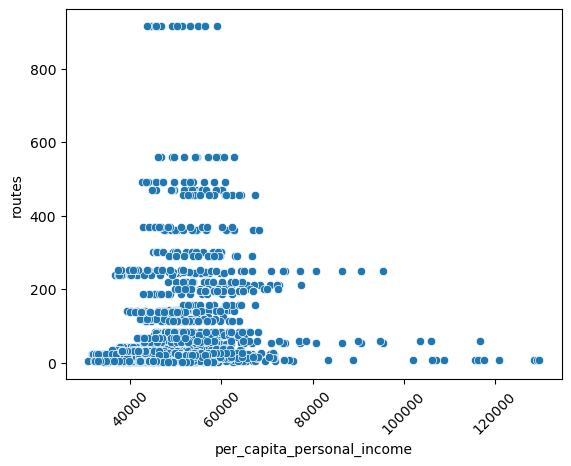

In [18]:
# routes as x-axis
# income as y axis
# airports as different colored lines

routes_income_df=tidied_df[['routes','per_capita_personal_income']]

routes_income_df.head()


routes_income_plt = sns.scatterplot(routes_income_df, \
    x = 'per_capita_personal_income', y = 'routes')

# sns.move_legend(routes_income_plt, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation = 45);


"Have the prices of flights from airports changed over time? Did an airport get more expensive compared to another?"

We can utilize a line chart with axes being "Year" and "Average Cost" to analyze long-term trends and spikes. We can see that the prices of flights change over time. Something interesting we've seen is that there has been a decrease in flight prices for most airport around 2018-2020 which coincides with the COVID-19 pandemic. Additionally, in the span of our time-series (2008-2022), flight prices for most airports have stayed stagnant or decreased slightly.

,airport_code,year,inflation_adjusted_avg_fare
0,CAK,2014,459.770111
1,CAK,2013,455.427454
2,CAK,2012,436.163692
3,CAK,2016,416.739085
4,CAK,2011,432.361017


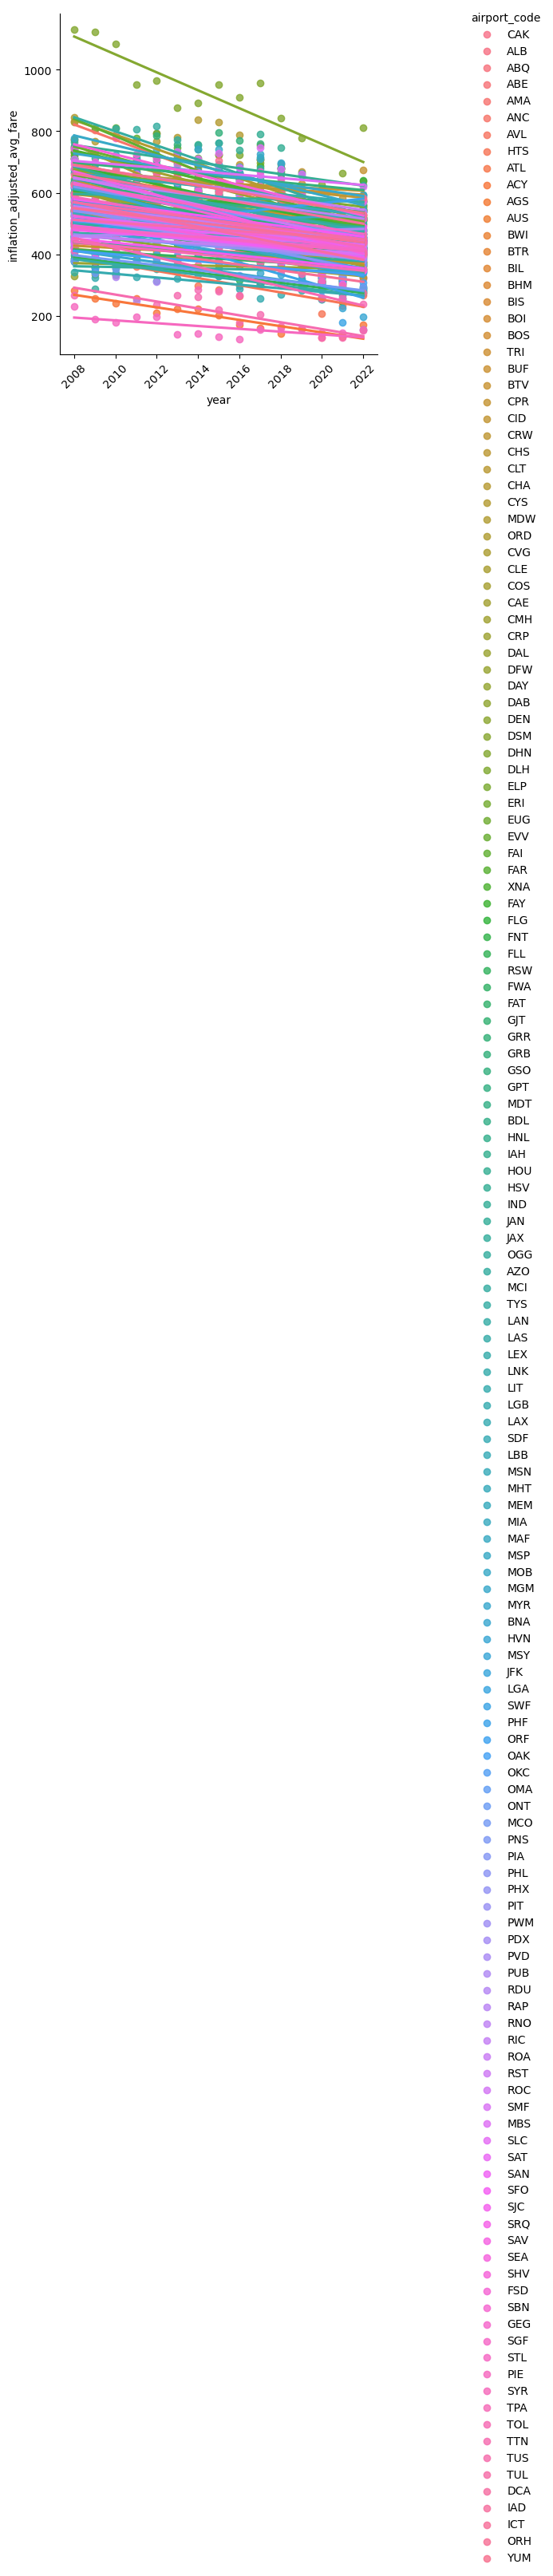

In [16]:
# year as x-axis
# average cost as y axis
# airports as different colored lines

cost_over_time_df = tidied_df[['airport_code', \
    'year', 'inflation_adjusted_avg_fare']]

cost_over_time_plt = sns.lmplot(cost_over_time_df, \
    x = 'year', y = 'inflation_adjusted_avg_fare', \
    hue = 'airport_code', \
    ci=None)

sns.move_legend(cost_over_time_plt, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation = 45);

cost_over_time_df.head()

#test

***
### **QUESTIONS FOR REVIEWERS**

1. Do the variables included in our dataset sufficient enough to actaully predict if there is correlation between socioeconomic status and flight price?

2. Should we take into consideration US colonies like Puerto Rico, and how that might impact our results?

3. Is there a way that we can improve our methodology in order for us to answer our research question as accurately as possible?